# Data Wrangling

https://www.cbp.gov/newsroom/stats

https://www.uscis.gov/tools/reports-and-studies/immigration-and-citizenship-data


In [1]:
# Imports
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
from yfinance import ticker
import json
from io import StringIO
import re
from rapidfuzz import process, fuzz
from joblib import Parallel, delayed
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Gets a list of all listed companies from SEC's EDGAR database
#"https://www.sec.gov/files/company_tickers.json"

with open('data/company_tickers.json', 'r') as f:
    data = json.load(f)
# companies = [entry["ticker"] for entry in response.values()]
# print(companies[:10])  # Print first 10 tickers

In [3]:
### WORK IN PROGRESS ###

# def read_tsv(file_path):
#     """Reads a TSV file with UTF-8 encoding."""
#     with open(file_path, "r", encoding="utf-8") as f:
#         return pd.read_csv(StringIO(f.read()), delimiter="\t", low_memory=False)
    
# remove_terms = [
#     "INCORPORATED", "INC", "CORPORATION", "CORP", "NA", "N A", "ENTERTAINMENT",
#     "CONSULTING", "FINANCIAL", "FINANCIALS", "LOGISTICS", "INDUSTRIES", "MANAGEMENT",
#     "LTD", "LIMITED", "LLC", "LLP", "PLC", "GROUP", "GRP", "GR", "HOLDINGS", "COMPANY",
#     "CO", "LP", "LL", "PARTNERSHIP", "TECHNOLOGIES", "SYSTEMS", "GLOBAL", "ENTERPRISES",
#     "SERVICES", "COM", "COMMUNICATIONS", "SOLUTIONS", "INVESTMENT", "PHARMACEUTICALS"
# ]
# remove_terms_pattern = re.compile(r'\b(' + '|'.join(remove_terms) + r')\b')
    
# def remove_meta_characters(input_string):
#     input_string = str(input_string)
#     input_string = re.sub(r'\s+', ' ', input_string).strip() 
#     input_string = remove_terms_pattern.sub('', input_string)
#     input_string = re.sub(r'/[^/]+/', ' ', input_string)
#     input_string = input_string.replace('.', '').replace(',', '').replace('&', 'AND')
#     input_string = re.sub(r'\s+', ' ', input_string).strip() 
#     return input_string

# def find_best_match(employer, standard_titles, company_mapping, score_cutoff=75):
#     matches = process.extract(employer, standard_titles, scorer=fuzz.token_set_ratio)
#     valid_matches = [match for match in matches if match[1] >= score_cutoff]
#     if valid_matches:
#         best_match_name = max(valid_matches, key=lambda x: x[1])[0]
#         return best_match_name, company_mapping.get(best_match_name)
#     return None, None

# def parallel_find_best_match(employers, standard_titles, company_mapping, n_jobs=-1):
#     return Parallel(n_jobs=n_jobs, backend="threading")(
#         delayed(find_best_match)(emp, standard_titles, company_mapping) for emp in employers)

# titles = [company['title'].upper() for company in data.values()]
# standard_titles = [remove_meta_characters(title) for title in titles]
# standard_titles = list(set(standard_titles))

# company_mapping = {remove_meta_characters(company['title']): company['ticker'] for company in data.values()}

# visa_files = {"h1b": ['data/visas/h1b_2016_2009.csv', 'data/visas/h1b_2019_2017.csv', 'data/visas/h1b_2024_2020.csv']}

# df_visas = []
# for visa_type, files in visa_files.items():
#     df_list = [read_tsv(file) for file in files]
#     df = pd.concat(df_list, axis=0)
#     df["employer"] = df["Employer (Petitioner) Name"].str.upper().apply(remove_meta_characters)
#     df.loc[:, "type"] = visa_type
#     df_visas.append(df)
 
# df_visas_combined = pd.concat(df_visas)

# drop_cols = ['Line by line', 'Employer (Petitioner) Name', 'Initial Denial', 'Continuing Denial']
# df_visas_clean = df_visas_combined.drop(drop_cols, axis = 1)
# df_visas_clean.columns = df_visas_clean.columns.str.strip()

# int_columns = ["Fiscal Year", "Tax ID", "Petitioner Zip Code", "Initial Approval", "Continuing Approval"]

# df_visas_clean[int_columns] = df_visas_clean[int_columns].apply(pd.to_numeric, errors="coerce").astype("Int64")

# sum_data = df_visas_clean.groupby(["Fiscal Year", "employer"], as_index=False).agg({
#     "Tax ID": "first",  
#     "Industry (NAICS) Code": "first",  
#     "Petitioner City": "first",  
#     "Petitioner State": "first",  
#     "Petitioner Zip Code": "first",  
#     "Initial Approval": "sum",  
#     "Continuing Approval": "sum",  
#     "type": "first"  
# })

# matches = parallel_find_best_match(sum_data["employer"], standard_titles, company_mapping, n_jobs=10)

# matches_df = pd.DataFrame(matches, columns=["matched_company", "ticker"])
# sum_data_filter = pd.concat([sum_data, matches_df], axis=1)

# sum_data_filter_narm = sum_data_filter[sum_data_filter["matched_company"].notna()]

# final_sum = sum_data_filter_narm.groupby(["Fiscal Year", "ticker"], as_index=False).agg({
#     "matched_company": "first",
#     "Tax ID": "first",  
#     "Industry (NAICS) Code": "first",  
#     "Petitioner City": "first",  
#     "Petitioner State": "first",  
#     "Petitioner Zip Code": "first",  
#     "Initial Approval": "sum",  
#     "Continuing Approval": "sum",  
#     "type": "first"  
# })

# final_sum.to_csv("data/final_sum.csv", index=False)

# # This code chunk took about 75 minutes to run and complete. My laptop and I are not on speaking terms.

In [4]:
h1b_df = pd.read_csv("data/final_sum.csv")
# Note: some large companies are omitted (AAPL, MRST) while others are most likely overestimated due to false positives (AAME, AABQ)
# I'll get around to fixing these issues after the midterm, though it should be sufficient for the proposal - Matt

# I no longer need the below chunks for debugging. Feel free to remove them if you feel the same. 

In [5]:

h1b_2009_path = 'data/visas/h1b_2016_2009.csv'
h1b_2017_path = 'data/visas/h1b_2019_2017.csv'
h1b_2020_path = 'data/visas/h1b_2024_2020.csv'

h2a_2015_path = 'data/visas/h2a_2019_2015.csv'
h2a_2020_path = 'data/visas/h2a_2024_2020.csv'

h2b_2015_path = 'data/visas/h2b_2019_2015.csv'
h2b_2020_path = 'data/visas/h2b_2025_2020.csv'

#Had to convert all encoding to UTF8 via notepad++
def read_tsv(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return pd.read_csv(StringIO(f.read()), delimiter="\t", low_memory=False)

# Read all files using the function
df_h1b_a = read_tsv(h1b_2009_path)
df_h1b_b = read_tsv(h1b_2017_path)
df_h1b_c = read_tsv(h1b_2020_path)

df_h2a_a = read_tsv(h2a_2015_path)
df_h2a_b = read_tsv(h2a_2020_path)

df_h2b_a = read_tsv(h2b_2015_path)
df_h2b_b = read_tsv(h2b_2020_path)

In [6]:
df_h1b = pd.concat([df_h1b_a, df_h1b_b, df_h1b_c], axis=0)

df_h2a = pd.concat([df_h2a_a, df_h2a_b], axis=0)

df_h2b = pd.concat([df_h2b_a, df_h2b_b], axis=0)


In [7]:
def remove_meta_characters(input_string):
    input_string = str(input_string)
    input_string = re.sub(r'\s+', ' ', input_string).strip() 
    input_string = re.sub(r'\b(INCORPORATED|INC|CORPORATION|CORP|NA|N A|LTD|LIMITED|LLC|LLP|PLC|GROUP|GRP|GR|HOLDINGS|COMPANY|CO|LP|PARTNERSHIP)\b',
                          '', str(input_string).upper())
    input_string = re.sub(r'/[^/]+/', ' ', input_string)
    input_string = input_string.replace('.', '').replace(',', '').replace('&', 'AND')
    input_string = re.sub(r'\s+', ' ', input_string).strip() 
    return input_string

In [8]:
titles = [company['title'].upper() for company in data.values()]

standard_titles = [remove_meta_characters(title) for title in titles]

In [9]:
df_h1b['employer'] = df_h1b['Employer (Petitioner) Name'].str.upper().apply(remove_meta_characters)
df_h2a['employer'] = df_h2a['Employer (Petitioner) Name'].str.upper().apply(remove_meta_characters)
df_h2b['employer'] = df_h2b['Employer (Petitioner) Name'].str.upper().apply(remove_meta_characters)

In [10]:
print('H1B Crossover Count: ' + str(sum(df_h1b["employer"].isin(standard_titles))))
print('H2A Crossover Count: ' + str(sum(df_h2a["employer"].isin(standard_titles))))
print('H2B Crossover Count: ' + str(sum(df_h2b["employer"].isin(standard_titles))))

H1B Crossover Count: 24060
H2A Crossover Count: 73
H2B Crossover Count: 50


In [11]:
df_h1b_listed = df_h1b[ df_h1b["employer"].isin(standard_titles) ].copy()
df_h1b_listed.loc[:, "type"] = 'h1b'

df_h2a_listed = df_h2a[ df_h2a["employer"].isin(standard_titles) ].copy()
df_h2a_listed.loc[:, "type"] = 'h2a'

df_h2b_listed = df_h2b[ df_h2b["employer"].isin(standard_titles) ].copy()
df_h2b_listed.loc[:, "type"] = 'h2b'

In [12]:
df_visas = pd.concat([df_h1b_listed, df_h2a_listed, df_h2b_listed])
df_visas.shape

(24183, 39)

In [13]:
df_visas.columns


Index(['Line by line', 'Fiscal Year   ', 'Employer (Petitioner) Name',
       'Tax ID', 'Industry (NAICS) Code', 'Petitioner City',
       'Petitioner State', 'Petitioner Zip Code', 'Initial Approval',
       'Initial Denial', 'Continuing Approval', 'Continuing Denial',
       'employer', 'type', 'Index()', 'Action Fiscal Year', 'Industry',
       'Occupation (SOC) Code', 'Worksite State', 'Consular_processed',
       'Wage Rate Band', 'New Employment Approval', 'New Employment Denial',
       'Continuation Approval', 'Continuation Denial',
       'Change with Same Employer Approval',
       'Change with Same Employer Denial', 'New Concurrent Approval',
       'New Concurrent Denial', 'Change of Employer Approval',
       'Change of Employer Denial', 'Amended Approval', 'Amended Denial',
       'Cap Fiscal Year', 'Cap Type', 'Work Site State', 'Consular_Processed',
       'Hourly Wage', 'ETA Case Number'],
      dtype='object')

In [14]:
drop_cols = ['Line by line', 'Employer (Petitioner) Name', 'Tax ID', 'Initial Denial', 'Continuing Denial', 'Index()', 'Consular_processed', 'New Employment Denial', 'Continuation Denial', 'Change with Same Employer Denial', 'New Concurrent Denial', 'Change of Employer Denial', 'Amended Denial', 'Consular_Processed', 'ETA Case Number']
df_visas_clean = df_visas.drop(drop_cols, axis = 1)

In [15]:
df_visas_clean.head()

,Fiscal Year,Industry (NAICS) Code,Petitioner City,Petitioner State,Petitioner Zip Code,Initial Approval,Continuing Approval,employer,type,Action Fiscal Year,...,New Employment Approval,Continuation Approval,Change with Same Employer Approval,New Concurrent Approval,Change of Employer Approval,Amended Approval,Cap Fiscal Year,Cap Type,Work Site State,Hourly Wage
63,2016.0,31-33 - Manufacturing,ROCK HILL,SC,29730.0,0,7,3D SYSTEMS,h1b,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,2016.0,31-33 - Manufacturing,SAINT PAUL,MN,55144.0,4,13,3M,h1b,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,2016.0,31-33 - Manufacturing,ST PAUL,MN,55144.0,2,8,3M,h1b,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,2016.0,NaN,SAN JOSE,CA,95131.0,12,8,8X8,h1b,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180,2016.0,"54 - Professional, Scientific, and Technical S...",SAN JOSE,CA,95131.0,0,1,8X8,h1b,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
import time
def fetch_stock_data(tickers):
    all_data = {}
    print('Downloading yfinance historical price data 2000/01/01 to 2025/03/16')
    num_downloaded = 0
    for ticker in tickers:
        try:
            data = yf.download(ticker, start="2000-01-01", end="2025-03-16", progress = False)
            all_data[ticker] = data
            num_downloaded +=1
            time.sleep(2.2)  # Sleep for 2 seconds between requests to avoid being blocked
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            time.sleep(2.2)

    print('Successfully downloaded ' + str(num_downloaded/len(tickers)))
    #Save a csv for offline work
    sp500_data = pd.concat(all_data, axis=1)
    sp500_data.to_csv("sp500_data.csv")
    
    print("S&P 500 historical data saved to sp500_data.csv")
    return sp500_data

#Only run this once on your system
#Make sure NOT to track the sp500_data csv
#sp500csv made for offline work
#fetch_stock_data

In [17]:
h1b_df['tot_app'] = h1b_df['Initial Approval'] + h1b_df['Continuing Approval']

In [18]:
h1b_df.head()

,Fiscal Year,ticker,matched_company,Tax ID,Industry (NAICS) Code,Petitioner City,Petitioner State,Petitioner Zip Code,Initial Approval,Continuing Approval,type,tot_app
0,2009,A,AGILENT,1414.0,"54 - Professional, Scientific, and Technical S...",WEST CHESTER,OH,45069.0,21,26,h1b,47
1,2009,AAME,ATLANTIC AMERICAN,7417.0,"21 - Mining, Quarrying, and Oil and Gas Extrac...",STRATHAM,NH,3885.0,682,472,h1b,1154
2,2009,AAOI,APPLIED OPTOELECTRONICS,194.0,31-33 - Manufacturing,WESTBURY,NY,11590.0,4,2,h1b,6
3,2009,AAON,AAON,5751.0,"54 - Professional, Scientific, and Technical S...",BREA,CA,92821.0,3,2,h1b,5
4,2009,AAP,ADVANCE AUTO PARTS,4233.0,52 - Finance and Insurance,ATLANTA,GA,30319.0,4,9,h1b,13


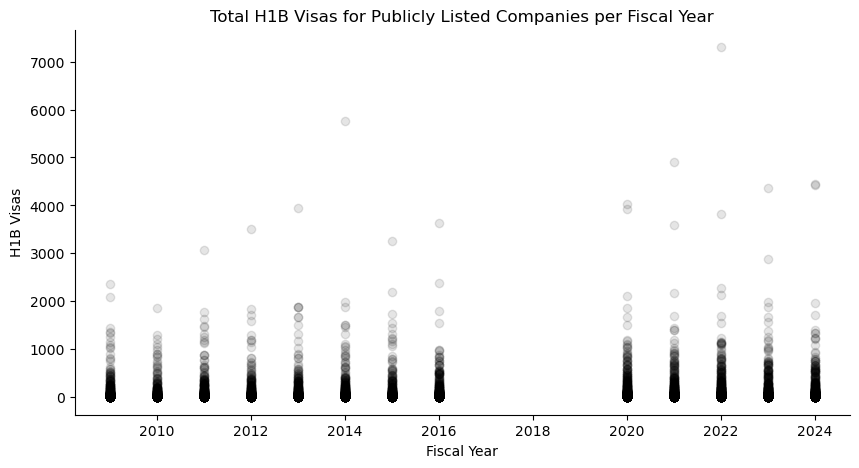

In [19]:
fig, ax = plt.subplots(figsize=(10,5)) 
ax.scatter('Fiscal Year', 'tot_app' ,data = h1b_df, color='black', alpha = .1)  

ax.set_ylabel('H1B Visas')
ax.set_xlabel('Fiscal Year')
ax.set_title('Total H1B Visas for Publicly Listed Companies per Fiscal Year')
sns.despine(ax=ax)

plt.show()

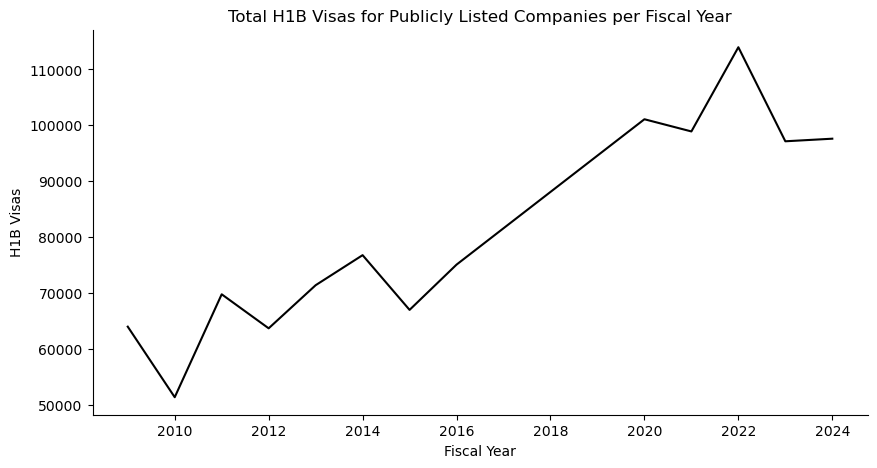

In [20]:
year_sums = h1b_df.groupby('Fiscal Year').sum().loc[:, ['tot_app']].reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'tot_app' ,data = year_sums, color='black')  
ax.set_ylabel('H1B Visas')
ax.set_xlabel('Fiscal Year')
ax.set_title('Total H1B Visas for Publicly Listed Companies per Fiscal Year')
sns.despine(ax=ax)

plt.show()


In [25]:
#Run once to have data locally
voo_data = yf.download('VOO', start="2008-01-01", end="2025-01-01", progress = False, interval='1wk')
#voo_data.to_csv('data/voo_hist_data.csv')
#voo_data = pd.read_csv('data/voo_hist_data.csv')
voo_data.head()

YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,VOO,VOO,VOO,VOO,VOO
Date,,,,,
2010-09-06,77.804451,78.354847,77.315211,78.354847,35100
2010-09-13,79.012283,79.409788,78.263132,78.706507,211300
2010-09-20,80.143631,80.602298,78.828803,79.302751,113800
2010-09-27,80.486687,81.224532,79.487518,80.686522,142600
2010-10-04,81.993103,82.039217,79.548989,80.901708,496900


In [26]:
voo_data['year'] = voo_data.index.year
yearly_voo = voo_data.groupby('year').mean().droplevel('Ticker', axis=1)
yearly_voo.head()

Price,Close,High,Low,Open,Volume
year,,,,,
2010,83.894027,84.346594,82.488777,83.438490,2.457647e+05
2011,90.351374,91.944938,88.499463,90.294928,1.089531e+06
2012,100.639404,101.689035,99.149784,100.294881,1.978665e+06
2013,123.059819,123.885113,121.346607,122.589876,4.896577e+06
2014,147.051357,148.269510,145.189708,146.769970,6.308038e+06


In [27]:
yearly_voo['vol_change'] = yearly_voo['Volume'].pct_change()
yearly_voo['open_change'] = yearly_voo['Open'].pct_change()
yearly_voo['close_change'] = yearly_voo['Close'].pct_change()
yearly_voo.head()

Price,Close,High,Low,Open,Volume,vol_change,open_change,close_change
year,,,,,,,,
2010,83.894027,84.346594,82.488777,83.438490,2.457647e+05,NaN,NaN,NaN
2011,90.351374,91.944938,88.499463,90.294928,1.089531e+06,3.433227,0.082174,0.076970
2012,100.639404,101.689035,99.149784,100.294881,1.978665e+06,0.816071,0.110748,0.113867
2013,123.059819,123.885113,121.346607,122.589876,4.896577e+06,1.474687,0.222294,0.222780
2014,147.051357,148.269510,145.189708,146.769970,6.308038e+06,0.288255,0.197244,0.194958


In [28]:
year_sums['chng'] = year_sums['tot_app'].pct_change()
year_sums.head(2)

,Fiscal Year,tot_app,chng
0,2009,63956,NaN
1,2010,51325,-0.197495


In [29]:
combined = yearly_voo.merge(year_sums, left_on='year', right_on='Fiscal Year')
combined.head(2)

,Close,High,Low,Open,Volume,vol_change,open_change,close_change,Fiscal Year,tot_app,chng
0,83.894027,84.346594,82.488777,83.438490,2.457647e+05,NaN,NaN,NaN,2010,51325,-0.197495
1,90.351374,91.944938,88.499463,90.294928,1.089531e+06,3.433227,0.082174,0.07697,2011,69754,0.359065


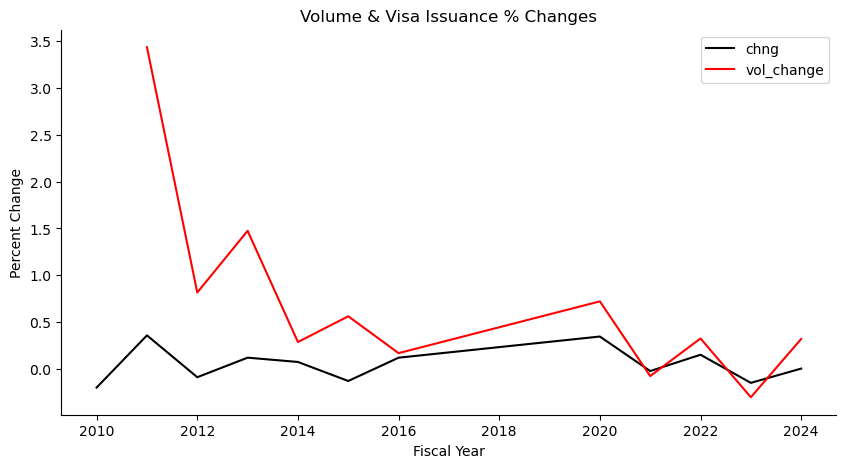

In [30]:

fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'chng' ,data = combined, color='black')  
ax.plot('Fiscal Year', 'vol_change' ,data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Volume & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)

plt.show()

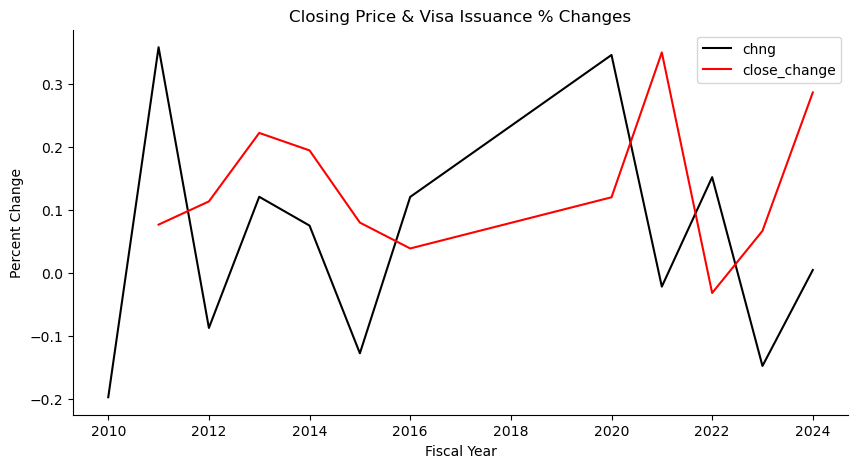

In [31]:

fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'chng' ,data = combined, color='black')  
ax.plot('Fiscal Year', 'close_change' ,data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Closing Price & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)

plt.show()

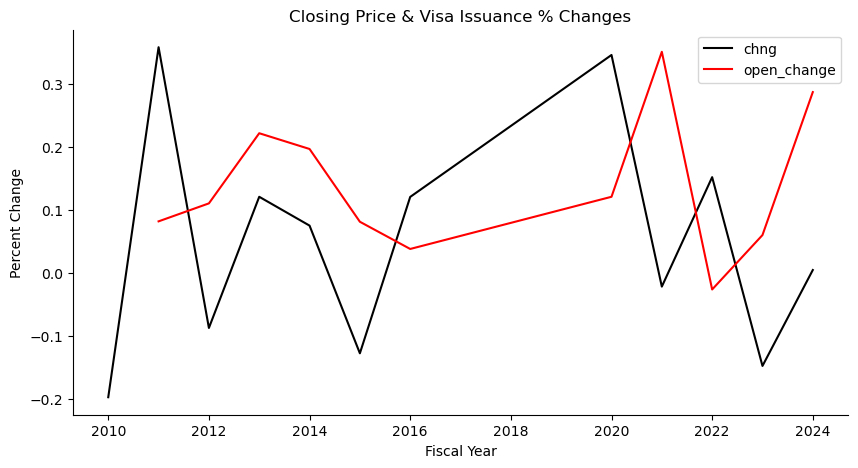

In [32]:

fig, ax = plt.subplots(figsize=(10,5)) 

ax.plot('Fiscal Year', 'chng' ,data = combined, color='black')  
ax.plot('Fiscal Year', 'open_change' ,data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Closing Price & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)

plt.show()

In [33]:
import time
def fetch_stock_info(tickers):
    #all_data = {}
    infor = {}
    dict_list = []
    print('Downloading yfinance information on select tickers...')
    for ticker in tickers:
        try:
            infor[ticker] = yf.Ticker(ticker).info
            time.sleep(2.001)  # Sleep for 2 seconds between requests to avoid being blocked

        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            time.sleep(2.001)
    return pd.DataFrame(infor)

In [34]:
company_info_df = fetch_stock_info(h1b_df['ticker'].unique())
company_info_df.to_csv('company_info_df.csv')

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ADMWF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ADMWF&crumb=zjPicD1gU3O


Error downloading ADMWF: 'NoneType' object has no attribute 'update'
Error downloading ALIV: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BCOV?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BCOV&crumb=zjPicD1gU3O


Error downloading BCOV: 'NoneType' object has no attribute 'update'
Error downloading BLTHD: list index out of range
Error downloading CNCL: list index out of range
Error downloading CUTR: list index out of range
Error downloading EMKR: list index out of range
Error downloading IVAC: list index out of range
Error downloading KNRX: list index out of range
Error downloading LGTY: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MRNS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MRNS&crumb=zjPicD1gU3O


Error downloading MRNS: 'NoneType' object has no attribute 'update'
Error downloading NVRO: list index out of range
Error downloading PFC: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SGLDF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SGLDF&crumb=zjPicD1gU3O


Error downloading SGLDF: 'NoneType' object has no attribute 'update'
Error downloading WDCVV: list index out of range
Error downloading WISA: list index out of range
Error downloading ZUO: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AE&crumb=zjPicD1gU3O


Error downloading AE: 'NoneType' object has no attribute 'update'
Error downloading SASR: list index out of range
Error downloading TPX: list index out of range
Error downloading BHLD: list index out of range
Error downloading HYB: list index out of range
Error downloading FFIEW: list index out of range
Error downloading KNWN: list index out of range
Error downloading RGPX: list index out of range


In [36]:
pd.read_csv('company_info_df.csv').T

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
Unnamed: 0,address1,city,state,zip,country,phone,fax,website,industry,industryKey,...,trailingThreeMonthNavReturns,netAssets,netExpenseRatio,newListingDate,address3,morningStarOverallRating,morningStarRiskRating,annualReportExpenseRatio,lastCapGain,annualHoldingsTurnover
A,5301 Stevens Creek Boulevard,Santa Clara,CA,95051,United States,800 227 9770,866 497 1134,https://www.agilent.com,Diagnostics & Research,diagnostics-research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAME,"4370 Peachtree Road, N.E.",Atlanta,GA,30319,United States,404 266 5500,NaN,https://www.atlam.com,Insurance - Life,insurance-life,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAOI,13139 Jess Pirtle Boulevard,Sugar Land,TX,77478,United States,(281) 295-1800,NaN,https://www.ao-inc.com,Communication Equipment,communication-equipment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAON,2425 South Yukon Avenue,Tulsa,OK,74107,United States,918 583 2266,918 583 6094,https://www.aaon.com,Building Products & Equipment,building-products-equipment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEE,2415 Cascade Pointe Boulevard,Charlotte,NC,28208,United States,980 221 3235,NaN,https://www.sealedair.com,Packaging & Containers,packaging-containers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TELNF,Snarøyveien 30,Fornebu,NaN,1360,Norway,47 81 07 70 00,NaN,https://www.telenor.com,Telecom Services,telecom-services,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VEVMQ,"3168, 262nd Street",Aldergrove,BC,V4W 2Z6,Canada,(604) 607-4000,(604) 607-4004,https://vicinitymotorcorp.com,Auto Manufacturers,auto-manufacturers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VICI,535 Madison Avenue,New York,NY,10022-2203,United States,646 949 4631,NaN,https://www.viciproperties.com,REIT - Diversified,reit-diversified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
